In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import load_model
import numpy as np
from keras.preprocessing import image
import cv2

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##   모델 로드

In [3]:
model = tf.keras.models.load_model('/content/drive/MyDrive/3차 프로젝트/VGG16_BatchNor.h5')

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

## 모델 input & last conv layer 세팅

In [5]:
# 이미지 사이즈
img_size = (250, 250)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# 마지막 convolution layer 확인
last_conv_layer_name_origin = "vgg16"
last_conv_layer_name = "block5_conv3"

In [6]:
# vgg16 layer 확인
last_conv_layer = model.get_layer(last_conv_layer_name_origin).summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

## image to array 함수 선언

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## functional type인 vgg16 함수내부 들어가는 클래스 선언

https://stackoverflow.com/questions/60623869/gradcam-with-guided-backprop-for-transfer-learning-in-tensorflow-2-0

In [8]:
class My_GradCAM:
    def __init__(self, model, classIdx, inner_model=None, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.inner_model = inner_model
        if self.inner_model == None:
            self.inner_model = model
        self.layerName = layerName 
        self.gradModel = tf.keras.models.Model(inputs=[self.inner_model.inputs],
                  outputs=[self.inner_model.get_layer(self.layerName).output,
                  self.inner_model.output]) 

In [9]:
cam = My_GradCAM(model, None, inner_model=model.get_layer("vgg16"), layerName="block5_conv3")

In [10]:
cam.gradModel

In [11]:
grad_model=cam.gradModel

## last convolution layer을 히트맵으로 만드는 함수 선언

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer('vgg16').get_layer(last_conv_layer_name).output, model.output]
#     )

    grad_model

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds #= preds[:, pred_index]
    

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## 이미지 로드

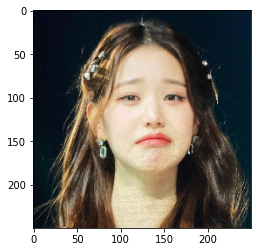

In [44]:
#이미지가 있는 로컬 경로
img_path = '/content/drive/MyDrive/3차 프로젝트/cropped_FifrziCUcAAXjrF.jpeg'
img_data = tf.keras.utils.load_img(img_path, target_size=(img_size))
plt.imshow(img_data)
plt.show()

## 이미지 to 배열

In [45]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## 마지막 layer 삭제

In [46]:
model.layers[-1].activation = None

## 이미지 예측

In [47]:
preds = model.predict(img_array)

1/1 [==============================] - 0s 16ms/step


In [48]:
preds

array([[-2.3180242,  0.3417673,  0.4277106,  3.3855808]], dtype=float32)

In [49]:
print("Predicted:", np.argmax(preds))

Predicted: 3


## 히트맵 만들기

In [50]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

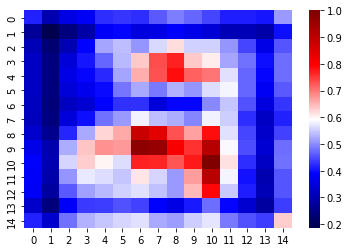

In [51]:
sns.heatmap(heatmap, cmap='seismic')

plt.show()

## 원본 사진에 히트맵 적용

In [52]:
import matplotlib.cm
print(matplotlib.cm.cmap_d.keys())

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

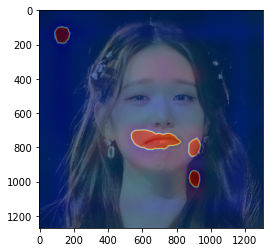

In [53]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("nipy_spectral")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

    img = cv2.imread(cam_path)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    a_component = lab[:,:,1]
    th = cv2.threshold(a_component,145,255,cv2.THRESH_BINARY)[1]
    
    blur = cv2.GaussianBlur(th,(13,13), 11)
    
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
    
    super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)

    plt.imshow(cv2.cvtColor(super_imposed_img, cv2.COLOR_BGR2RGB))


save_and_display_gradcam(img_path, heatmap)